In [19]:
import torch
import torch.utils.data
from skimage.io import imread
import cv2
import json
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import make_grid
import torchvision
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import h5py
from tqdm import tqdm_notebook as tqdm

### Use *torchvision* helpers to load the dataset

In [20]:
images = ImageFolder('E:/temp/hand_labels_synth/hand_labels_synth')
# for this to work, one needs to delete 'output_viz_synth' because it includes images that ruin the alignment
joints = DatasetFolder('E:/temp/hand_labels_synth/hand_labels_synth',
                       loader=lambda x: np.asarray(json.load(open(x, 'r'))['hand_pts']), extensions='json')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, window_size=(64,64), augmentation=100):
        super(Dataset, self).__init__()
        self.window_size = window_size
        self.augmentation = augmentation
        
    def __len__(self):
        return len(images) * self.augmentation

    def random_state(self, idx_):
        seed = np.random.get_state()
        np.random.seed(idx_)
        
        class state:
            idx = idx_ // self.augmentation
            angles = np.random.rand(20)
            scales = np.random.randn(20)
            perspective = np.random.randn(20, 4, 2)
            translation = np.random.randn(20, 2)
            color = np.random.randn(3)
            blur_amount= np.random.rand()
            noise_amount = np.random.randn()
            noise = np.random.randn(*self.window_size, 3)
            
        np.random.set_state(seed)
        
        return state()
    
    def apply_transform_to_image(self, transform, img):
        return cv2.warpPerspective(img, np.linalg.inv(transform), self.window_size, borderValue=np.nan)
        
    def apply_transform_to_joints(self, transform, J):
        w, h = self.window_size
        nz = J[...,-1] != 0.0
        JJ = (np.linalg.inv(transform) @ J.T).T
        JJ[nz] /= JJ[nz,-1][...,np.newaxis]
        JJ[JJ[:,0] < 0] = 0
        JJ[JJ[:,0] >= w] = 0
        JJ[JJ[:,1] < 0] = 0
        JJ[JJ[:,1] >= h] = 0
        return JJ

    def check_transform(self, W, H, transform, J):
        w, h = self.window_size
        window = np.array([[0, 0, 1], [w-1, 0, 1], [w-1, h-1, 1], [0, h-1, 1]])
        X, Y, Z = transform @ window.T
        X /= Z
        Y /= Z
        J = self.apply_transform_to_joints(transform, J)
        # we need the transform to be a window within the image, so that at least 5 joints are visible
        return np.all((X >= 0) & (X < W-1) & (Y >= 0) & (Y < H-1)) and (J[...,-1] != 0).sum() > 15
    
    def get_transform(self, state):
        idx = state.idx
                
        # fetch from the loadeds
        img, _ = images[idx]
        img = np.array(img)
        J, _ = joints[idx]
        H, W = img.shape[:2]
        h, w = self.window_size
        
        # keep valid joints (not all images have all joints)
        X = J[...,0]
        Y = J[..., 1]
        Z = J[..., 2]
        valid = (X > 0) & (Y > 0) & (X < W) & (Y < H) & (Z != 0)
        j = J[valid,:2]
        
        # get bounds
        if len(j):
            upper_left = j.min(axis=0)
            bottom_right = j.max(axis=0)
        else:
            upper_left = np.array([0, 0])
            bottom_right = np.array([H, W])
        
        # compute center and scale
        center = 0.5 * upper_left + 0.5 * bottom_right
        scale = np.linalg.norm(upper_left - bottom_right) * 0.5
        
        # recompute bounds for an inscribing circle
        upper_left = center - scale
        bottom_right = center + scale
                
        # generate the initial perspective transform (to further purturb for augmentation)
        transform = np.eye(3)
        transform[:2,2] = upper_left
        transform[0, 0] = 2 * scale / w
        transform[1, 1] = 2 * scale / h
        
        # pivot transform
        pivot = np.eye(3)
        pivot[:2,2] = [-w/2, -h/2]
        ipivot = np.linalg.inv(pivot)

        # tries transform on local transform variable
        def try_transform(base_transform, T, J):
            for effort in range(20):
                t = ipivot @ T() @ pivot
                if self.check_transform(W, H, base_transform @ t, J):
                    return base_transform @ t;
            return base_transform
            
        # sample rotation around center
        angle = iter(state.angles)
        def generate_rotation():
            theta = next(angle) * 2 * np.pi
            c, s = np.cos(theta), np.sin(theta)
            return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
                        
        # sample scale around center (32, 32)
        scale = iter(state.scales)
        def generate_scaling():
            s = np.maximum(1e-2, next(scale) + 1)
            return np.array([[s, 0, 0], [0, s, 0], [0, 0, 1]])
        
        # sample perspective distortion
        perspective = iter(state.perspective)
        def generate_perspective():
            points = np.array([[0, 0],
                               [w-1, 0],
                               [w-1, h-1],
                               [0, h-1]])
            targets = points + next(perspective) * 0.1 * max(w, h)
            return cv2.findHomography(points, targets)[0]
        
        # sample translation
        translation = iter(state.translation)
        def generate_translation():
            T = np.eye(3)
            T[:2,2] = 0.1 * next(translation) * [w, h]
            return T
        
        for rnd_trans in [generate_rotation, generate_scaling, generate_perspective, generate_translation]:
            transform = try_transform(transform, rnd_trans, J)
        
        return transform
    
    def get_transform_corners(self, transform):
        w, h = self.window_size
        points = np.array([[0, 0, 1],
                           [w-1, 0, 1],
                           [w-1, h-1, 1],
                           [0, h-1, 1]])
        points = transform @ points.T
        X, Y, Z = points
        X /= Z
        Y /= Z
        return points[:2,...].T
    
    def __getitem__(self, idx_):
        state = self.random_state(idx_)
        transform = self.get_transform(state)

        # to float32
        img = np.array(images[state.idx][0]).astype(np.float32) / 255.

        # generate transformed image and joints
        img = self.apply_transform_to_image(transform, img)
        J = self.apply_transform_to_joints(transform, joints[state.idx][0])
        
        # sample HS tampering in HSV
        HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
        # H is degrees [0, 360), S, V are [0, 1]
        HSV += 0.1 * state.color * [ 0, 1, 1 ]
        HSV = np.float32(np.maximum([0, 0, 0], np.minimum([360, 1, 1], HSV)))
        img = cv2.cvtColor(HSV, cv2.COLOR_HSV2BGR_FULL)
        
        # sample blur
        sigma = 2 * np.maximum(0, state.blur_amount)
        img = cv2.GaussianBlur(img, None, sigma)
        
        # sample noise
        img = img + state.noise_amount * 0.01 * state.noise
        
        # clip image
        img = np.maximum(0, np.minimum(1, img))
                        
        # return
        return img.transpose(2, 0, 1), J

### Visualize selected boxes

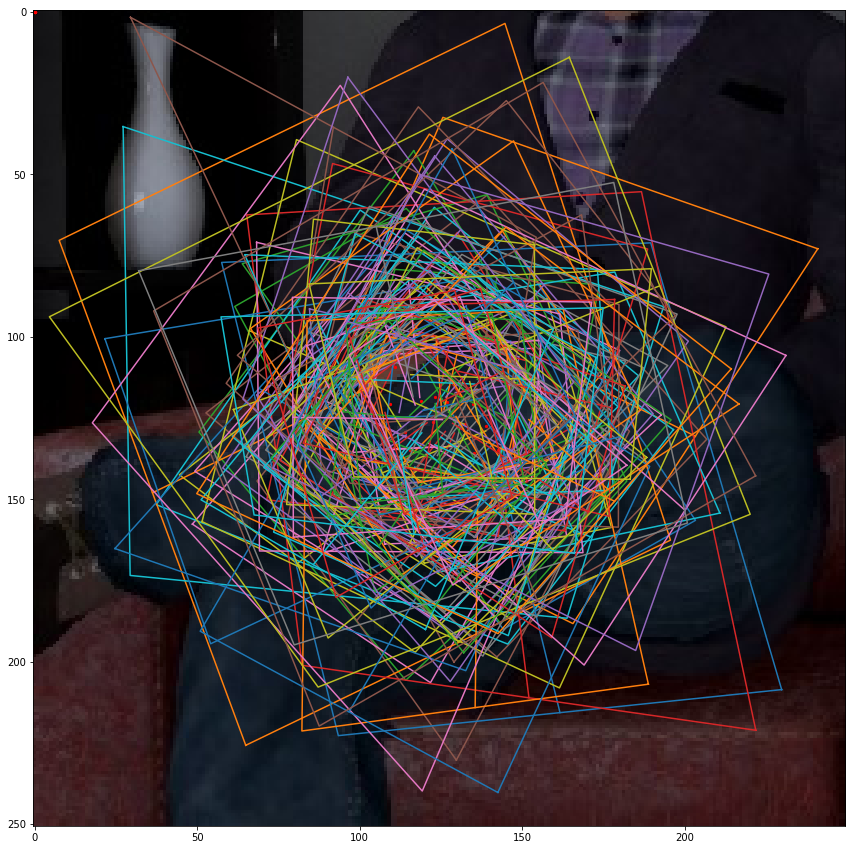

In [21]:
ds = Dataset(window_size=(256, 256))
states = [ ds.random_state(idx) for idx in range(1000, 1100) ]
plt.figure(figsize=(15,15))
plt.imshow(images[states[0].idx][0])
plt.scatter(joints[states[0].idx][0][:,0], joints[states[0].idx][0][:,1], c='red', s=5)

for state in states:
    transform = ds.get_transform(state)
    P = ds.get_transform_corners(transform)
    up_center = (P[0] + P[1]) / 2
    center = (P[0] + P[2]) / 2
    X, Y = P.T
    X = X.tolist() + [X[0]]
    Y = Y.tolist() + [Y[0]]
    [p] = plt.plot(X, Y)
    plt.plot([up_center[0], center[0]], [up_center[1], center[1]], color=p.get_color())

### Visualize some results

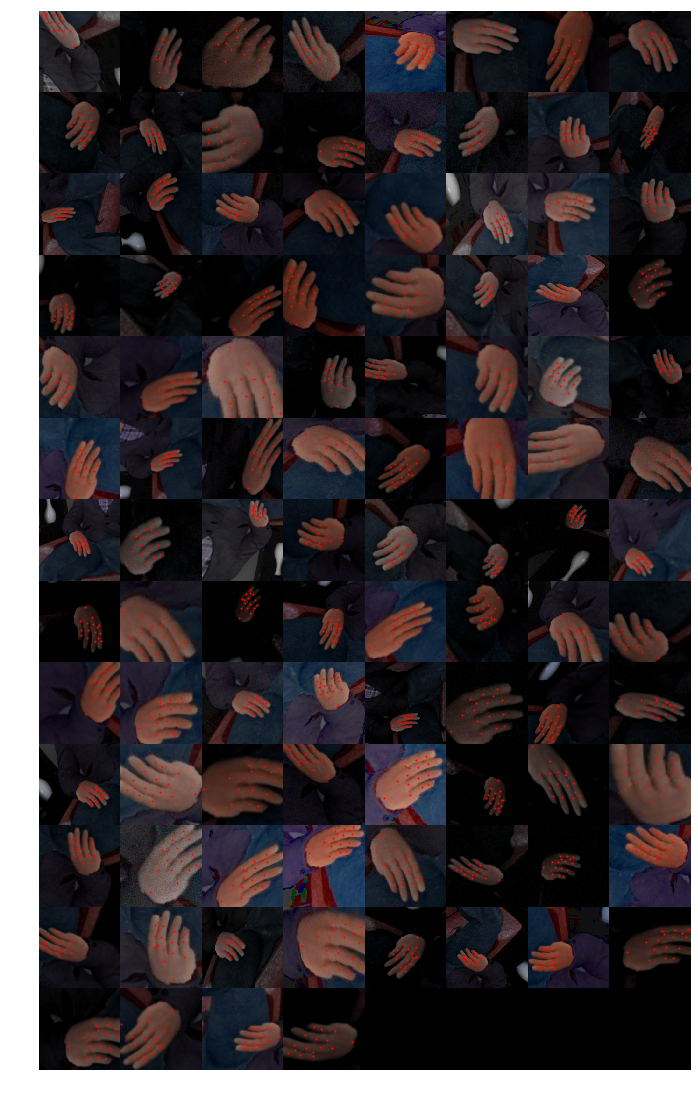

In [22]:
ds = Dataset(window_size=(256, 256))
dl = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)

# Visualize some results

X, Y = iter(dl).next()
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(make_grid(X, padding=0, normalize=False, scale_each=False).permute(1, 2, 0))
for i, J in enumerate(Y):
    J = J[J[...,-1]!=0]
    offset_x = (i % 8) * X.shape[2]
    offset_y = (i // 8) * X.shape[2]
    
    plt.scatter(J[...,0] + offset_x,
                J[...,1] + offset_y,
                c = 'red', s=1)
plt.tight_layout(pad=0)

### Save to HDF5

In [ ]:
file_out = '../datasets/color_right_hand.h5'

if __name__ == '__main__':
    with h5py.File(file_out, 'w') as out:
        ds = Dataset()
        dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=0)
        # If I don't use chunks, I can't break before the entire 46GB file is dumped (takes too long)
        images_dset = out.create_dataset('images',
                                         shape=(0, 3, 64, 64),
                                         maxshape=(None,3,64,64),
                                         dtype='float',
                                         chunks=(64, 3,64, 64))
        joints_dset = out.create_dataset('joints',
                                         shape=(0, 21, 3),
                                         maxshape=(None, 21, 3),
                                         dtype='float',
                                         chunks=(64, 21, 3))

        offset = 0
        invalid = 0
        for X, Y in tqdm(dl):
            B = X.shape[0]
            valid_images = torch.isnan(X).view(B, -1).sum(dim=1) == 0
            N = valid_images.sum()
            invalid += B - N
            if N > 1:
                images_dset.resize(images_dset.shape[0] + N, axis=0)
                images_dset[-N:] = X[valid_images]
                joints_dset.resize(joints_dset.shape[0] + N, axis=0)
                joints_dset[-N:] = Y[valid_images]
                offset += N
        print('Total invalid: ', invalid)

### Load from HDF5

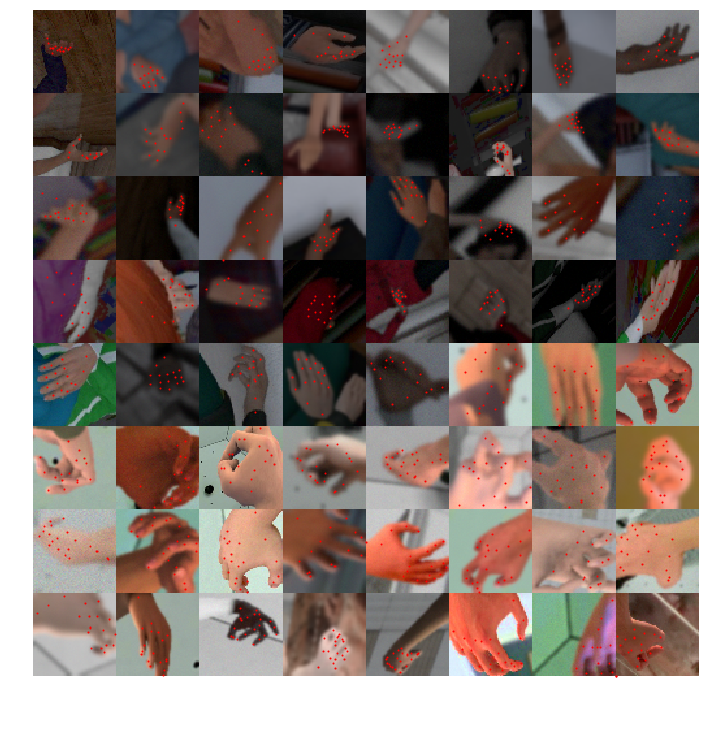

In [23]:
file_in = '../datasets/color_right_hand.h5'

with h5py.File(file_in, 'r') as ds:
    plt.figure(figsize=(10,10))
    plt.axis('off')
    images = ds['images']
    joints = ds['joints']
    indices = np.random.permutation(images.shape[0])[:64]
    images = images[sorted(indices.tolist())]
    joints = joints[sorted(indices.tolist())]
    B, _, H, W = images.shape
    
    grid = make_grid(torch.tensor(images), padding=0, nrow=int(np.sqrt(B)))
    plt.imshow(grid.permute(1, 2, 0))
    
    for i, J in enumerate(joints):
        J = J[J[...,-1]!=0]
        offset_x = (i % (grid.shape[-1] / W)) * W
        offset_y = (i // (grid.shape[-1] / W)) * W

        plt.scatter(J[...,0] + offset_x,
                    J[...,1] + offset_y,
                    c = 'red', s=1)
    plt.tight_layout(pad=0)